In [39]:
%matplotlib inline

import os

import random
import numpy as np
import tensorflow as tf
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

In [40]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [65]:
!unzip /content/drive/MyDrive/kagglecatsanddogs_5340.zip -d /dados

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: /dados/PetImages/Dog/5500.jpg  
  inflating: /dados/PetImages/Dog/5501.jpg  
  inflating: /dados/PetImages/Dog/5502.jpg  
  inflating: /dados/PetImages/Dog/5503.jpg  
  inflating: /dados/PetImages/Dog/5504.jpg  
  inflating: /dados/PetImages/Dog/5505.jpg  
  inflating: /dados/PetImages/Dog/5506.jpg  
  inflating: /dados/PetImages/Dog/5507.jpg  
  inflating: /dados/PetImages/Dog/5508.jpg  
  inflating: /dados/PetImages/Dog/5509.jpg  
  inflating: /dados/PetImages/Dog/551.jpg  
  inflating: /dados/PetImages/Dog/5510.jpg  
  inflating: /dados/PetImages/Dog/5511.jpg  
  inflating: /dados/PetImages/Dog/5512.jpg  
  inflating: /dados/PetImages/Dog/5513.jpg  
  inflating: /dados/PetImages/Dog/5514.jpg  
  inflating: /dados/PetImages/Dog/5515.jpg  
  inflating: /dados/PetImages/Dog/5516.jpg  
  inflating: /dados/PetImages/Dog/5517.jpg  
  inflating: /dados/PetImages/Dog/5518.jpg  
  inflating: /dados/PetImages/Dog/5519.jpg

In [66]:
root = '/dados/PetImages'
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]

print(categories)

['/dados/PetImages/Cat', '/dados/PetImages/Dog']


This function is useful for pre-processing the data into an image and input vector.

In [67]:
# helper function to load image and return it and input vector
def get_image(path):
    img = tf.keras.utils.load_img(path, target_size=(224, 224))
    x = tf.keras.utils.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

In [68]:
#Remove the Thumbs.db file in the database
os.remove('/dados/PetImages/Cat/Thumbs.db')
os.remove('/dados/PetImages/Dog/Thumbs.db')

In [69]:
#Since there was too many images, we are going to remove most of them and use just the first 500 images
for i in range(500, 12499):
  os.remove(f'/dados/PetImages/Cat/{i}.jpg')
  os.remove(f'/dados/PetImages/Dog/{i}.jpg')

Load all the images from root folder

In [70]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames 
              in os.walk(category) for f in filenames 
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c})

# count the number of classes
num_classes = len(categories)

Randomize the data order.

In [71]:
random.shuffle(data)

create training / validation / test split (70%, 15%, 15%)

In [72]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

Separate data for labels.

In [73]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0]


Pre-process the data as before by making sure it's float32 and normalized between 0 and 1.

In [74]:
# normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(151, 2)


Let's get a summary of what we have.

In [75]:
# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)


finished loading 1002 images from 2 categories
train / validation / test split: 701, 150, 151
training data shape:  (701, 224, 224, 3)
training labels shape:  (701, 2)


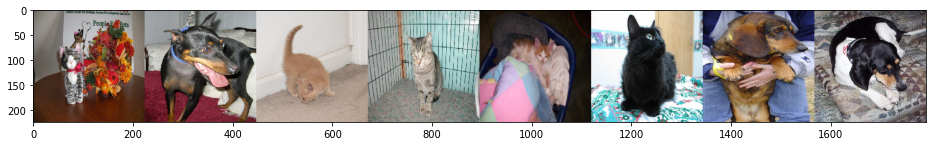

In [76]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [tf.keras.utils.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

In [77]:
# build the network
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (224, 224, 3)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 activation_12 (Activation)  (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 activation_13 (Activation)  (None, 109, 109, 32)      0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                 

In [78]:
# compile the model to use categorical cross-entropy loss function and adadelta optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))


Epoch 1/10
6/6 [==============================] - 3s 394ms/step - loss: 0.7393 - accuracy: 0.4907 - val_loss: 0.6949 - val_accuracy: 0.4467
Epoch 2/10
6/6 [==============================] - 1s 169ms/step - loss: 0.6900 - accuracy: 0.5235 - val_loss: 0.6920 - val_accuracy: 0.5133
Epoch 3/10
6/6 [==============================] - 1s 170ms/step - loss: 0.6884 - accuracy: 0.5178 - val_loss: 0.6936 - val_accuracy: 0.4533
Epoch 4/10
6/6 [==============================] - 1s 170ms/step - loss: 0.6869 - accuracy: 0.5093 - val_loss: 0.6862 - val_accuracy: 0.5533
Epoch 5/10
6/6 [==============================] - 1s 170ms/step - loss: 0.6784 - accuracy: 0.6120 - val_loss: 0.6784 - val_accuracy: 0.6000
Epoch 6/10
6/6 [==============================] - 1s 171ms/step - loss: 0.6659 - accuracy: 0.5635 - val_loss: 0.6637 - val_accuracy: 0.6000
Epoch 7/10
6/6 [==============================] - 1s 170ms/step - loss: 0.6578 - accuracy: 0.6049 - val_loss: 0.6384 - val_accuracy: 0.6533
Epoch 8/10
6/6 [====

Let's plot the validation loss and validation accuracy over time.

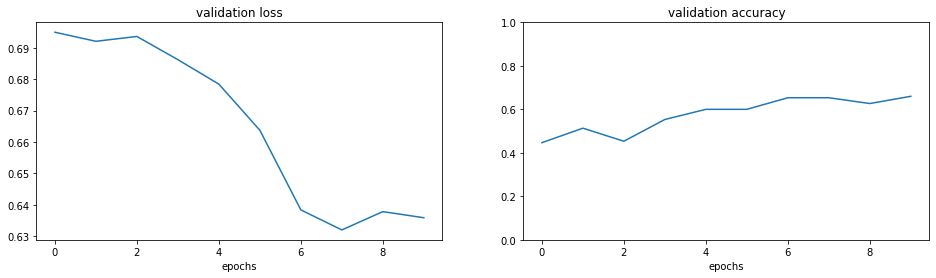

In [88]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [80]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.6191247701644897
Test accuracy: 0.6754966974258423


In [81]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

553467096/553467096 [==============================] - 17s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [82]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)


In [83]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [84]:
history2 = model_new.fit(x_train, y_train, 
                         batch_size=128, 
                         epochs=10, 
                         validation_data=(x_val, y_val))


Epoch 1/10
6/6 [==============================] - 24s 2s/step - loss: 1.0018 - accuracy: 0.5021 - val_loss: 0.8089 - val_accuracy: 0.5533
Epoch 2/10
6/6 [==============================] - 5s 779ms/step - loss: 0.7252 - accuracy: 0.5592 - val_loss: 0.5733 - val_accuracy: 0.7733
Epoch 3/10
6/6 [==============================] - 5s 772ms/step - loss: 0.5761 - accuracy: 0.7019 - val_loss: 0.6011 - val_accuracy: 0.5533
Epoch 4/10
6/6 [==============================] - 5s 769ms/step - loss: 0.5226 - accuracy: 0.7047 - val_loss: 0.5067 - val_accuracy: 0.7267
Epoch 5/10
6/6 [==============================] - 4s 764ms/step - loss: 0.4814 - accuracy: 0.7703 - val_loss: 0.4808 - val_accuracy: 0.7533
Epoch 6/10
6/6 [==============================] - 4s 761ms/step - loss: 0.4354 - accuracy: 0.8088 - val_loss: 0.3956 - val_accuracy: 0.8600
Epoch 7/10
6/6 [==============================] - 4s 756ms/step - loss: 0.4201 - accuracy: 0.8188 - val_loss: 0.3720 - val_accuracy: 0.8667
Epoch 8/10
6/6 [======

Our validation accuracy hovers close to 80% towards the end, which is more than 30% improvement on the original network trained from scratch (meaning that we make the wrong prediction on 20% of samples, rather than 50%). 

It's worth noting also that this network actually trains _slightly faster_ than the original network, despite having more than 100 times as many parameters! This is because freezing the weights negates the need to backpropagate through all those layers, saving us on runtime.

Let's plot the validation loss and accuracy again, this time comparing the original model trained from scratch (in blue) and the new transfer-learned model in green.

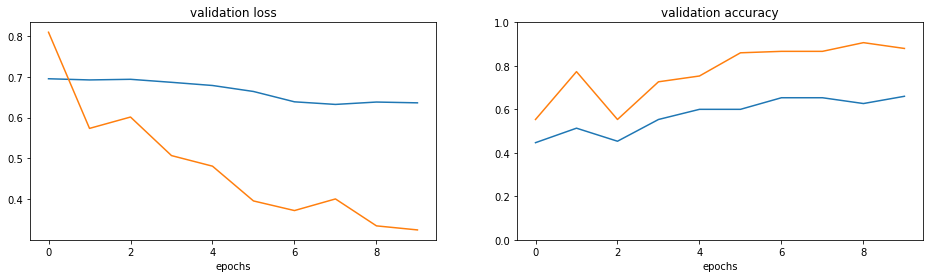

In [87]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [89]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.33416080474853516
Test accuracy: 0.8741722106933594


To predict a new image, simply run the following code to get the probabilities for each class.

In [93]:
img, x = get_image('/dados/PetImages/Dog/102.jpg')
probabilities = model_new.predict([x])


1/1 [==============================] - 1s 1s/step
